# 3-Gram Language Model
* Text Retrieval and Mining, BSc BAN, 2023-2024
* Author: [Julien Rossi](mailto:j.rossi@uva.nl)



We will use the **Reuters** dataset, included in nltk.

It is a collection of business-related short articles.

# Import and Prepare Data

As it is a builtin dataset, it is easy to retrieve.

In [ ]:
import nltk
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd

from nltk.corpus import reuters

data = [{'id': i, 'fulltext': ' '.join(s), 'nbwords': len(s), 'tokens': s} for i, s in enumerate(reuters.sents())]
df = pd.DataFrame(data)

In [ ]:
print(f'There are {df.shape[0]} documents in the corpus.')

There are 54716 documents in the corpus.


In [ ]:
df.iloc[1]["fulltext"]

'They told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And lead to curbs on American imports of their products .'

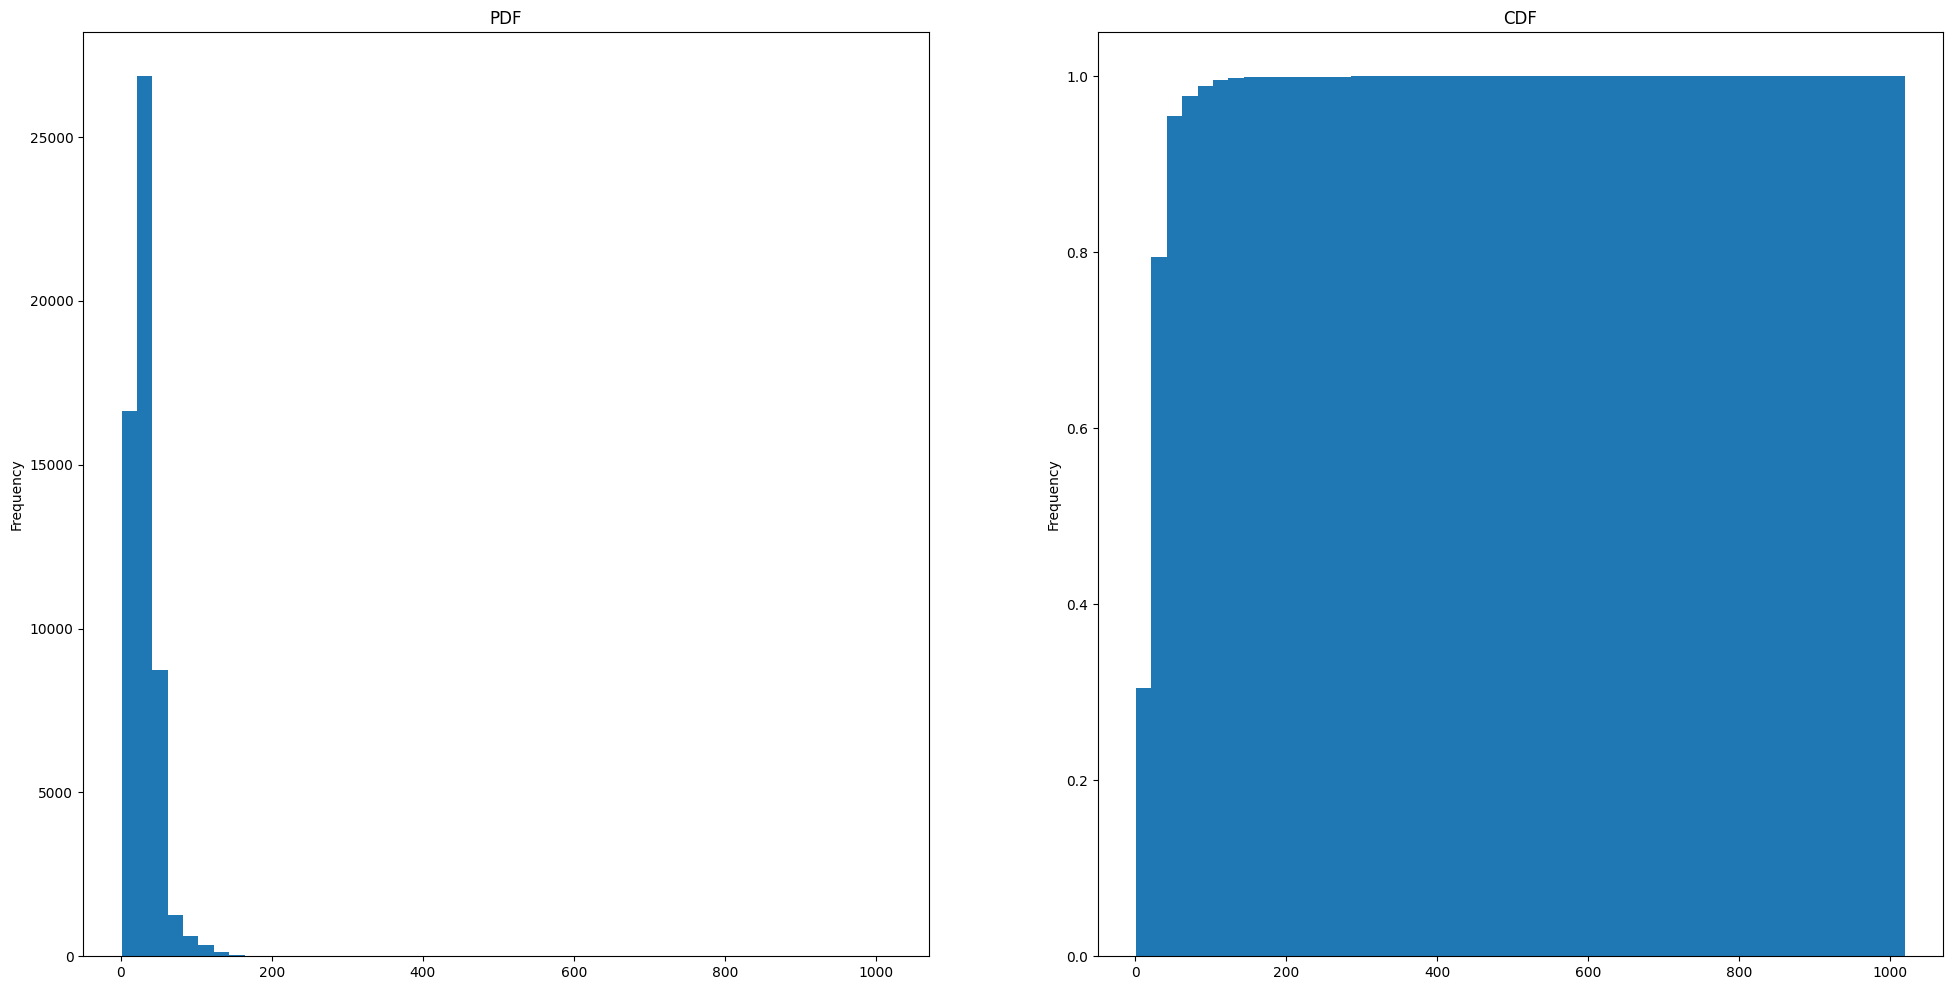

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))

_ = df['nbwords'].plot.hist(bins=50, ax=axs[0])
_ = df['nbwords'].plot.hist(cumulative=True, density=1, bins=50, ax=axs[1])

_ = axs[0].set_title('PDF')
_ = axs[1].set_title('CDF')

In [ ]:
from termcolor import colored
from textwrap import fill

# Reuters corpus is already tokenized
sample = df.sample(n=1).iloc[0]
index = sample['id']
document = sample['tokens']

print(f'{colored("Sample text from Reuters:", attrs=["bold"])} #{index}')
print('*' * 80)
print(f'{colored("Original Data:", color="blue", attrs=["bold"])}\n{document[:5]} (...)\n(...) {document[-5:]}')
print('*' * 80)
print(f'{colored("Full Text:", color="blue", attrs=["bold"])}')
print(fill(' '.join(document), width=80))


Sample text from Reuters: #46735
********************************************************************************
Original Data:
['Yesterday', ',', 'the', 'federal', 'department'] (...)
(...) ['and', '30', 'last', 'year', '.']
********************************************************************************
Full Text:
Yesterday , the federal department of energy charged Gulf Canada with eight
counts of illegal dumping for discharging powdered cement and drilling mud
between September 23 and 30 last year .


# Bigrams / TriGrams

NLTK has special functions that can generate the list of 2-grams and 3-grams of a document.

Padded 2-grams add `(None, 'The')` as a 2-gram when the sentence starts with 'The'.

As we build a 3-Gram LM, we focus on padded 3-grams from the corpus.

In [ ]:
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

# Get the bigrams
print(colored('BIGRAMS: ', attrs=['bold']), list(bigrams(document))) # [(u'ASIAN', u'EXPORTERS'), (u'EXPORTERS', u'FEAR'), (u'FEAR', u'DAMAGE'), (u'DAMAGE', u'FROM'), ...

# Get the padded bigrams
print(colored('PADDED BIGRAMS: ', attrs=['bold']), list(bigrams(document, pad_left=True, pad_right=True))) # [(None, u'ASIAN'), (u'ASIAN', u'EXPORTERS'), (u'EXPORTERS', u'FEAR'), (u'FEAR', u'DAMAGE'), (u'DAMAGE', u'FROM'),
print()
# Get the trigrams
print(colored('TRIGRAMS: ', attrs=['bold']), list(trigrams(document))) # [(u'ASIAN', u'EXPORTERS', u'FEAR'), (u'EXPORTERS', u'FEAR', u'DAMAGE'), (u'FEAR', u'DAMAGE', u'FROM'), ...

# Get the padded trigrams
print(colored('PADDED TRIGRAMS: ', attrs=['bold']), list(trigrams(document, pad_left=True, pad_right=True))) # [(None, None, u'ASIAN'), (None, u'ASIAN', u'EXPORTERS'), (u'ASIAN', u'EXPORTERS', u'FEAR'), (u'EXPORTERS', u'FEAR', u'DAMAGE'), (u'FEAR', u'DAMAGE', u'FROM') ...


BIGRAMS:  [('Yesterday', ','), (',', 'the'), ('the', 'federal'), ('federal', 'department'), ('department', 'of'), ('of', 'energy'), ('energy', 'charged'), ('charged', 'Gulf'), ('Gulf', 'Canada'), ('Canada', 'with'), ('with', 'eight'), ('eight', 'counts'), ('counts', 'of'), ('of', 'illegal'), ('illegal', 'dumping'), ('dumping', 'for'), ('for', 'discharging'), ('discharging', 'powdered'), ('powdered', 'cement'), ('cement', 'and'), ('and', 'drilling'), ('drilling', 'mud'), ('mud', 'between'), ('between', 'September'), ('September', '23'), ('23', 'and'), ('and', '30'), ('30', 'last'), ('last', 'year'), ('year', '.')]
PADDED BIGRAMS:  [(None, 'Yesterday'), ('Yesterday', ','), (',', 'the'), ('the', 'federal'), ('federal', 'department'), ('department', 'of'), ('of', 'energy'), ('energy', 'charged'), ('charged', 'Gulf'), ('Gulf', 'Canada'), ('Canada', 'with'), ('with', 'eight'), ('eight', 'counts'), ('counts', 'of'), ('of', 'illegal'), ('illegal', 'dumping'), ('dumping', 'for'), ('for', 'disch

In [ ]:
model = defaultdict(lambda: defaultdict(lambda: 0))

for tokens in df['tokens']:
    for w1, w2, w3 in trigrams(tokens, pad_right=True, pad_left=True):
        model[(w1.lower() if w1 is not None else None, w2.lower() if w2 is not None else None)][w3.lower() if w3 is not None else None] += 1

In [ ]:
print(f'Number of times "economists" followed "what the": {model["what", "the"]["economists"]}') # "economists" follows "what the" 2 times
print(f'Number of sentences starting with "the": {model[None, None]["the"]}')

Number of times "economists" followed "what the": 2
Number of sentences starting with "the": 8865


In [ ]:
print(model["what", "the"]["nonexistingword"]) # 0 times, thanks to the defaultdict definition

0


In [ ]:
# Let's transform the counts to probabilities
for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

In [ ]:
print(f'Probability of "economists" given "what the": {model["what", "the"]["economists"]}') # "economists" follows "what the" 2 times
print(f'Probability of "the" given Start_of_Sentence: {model[None, None]["the"]}') # 8839 sentences start with "The"

Probability of "economists" given "what the": 0.041666666666666664
Probability of "the" given Start_of_Sentence: 0.1620184223992982


In [ ]:
model['what', 'the']

defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
            {'communique': 0.020833333333333332,
             'chance': 0.020833333333333332,
             'manager': 0.020833333333333332,
             'central': 0.041666666666666664,
             'announcement': 0.020833333333333332,
             'minister': 0.020833333333333332,
             'minimum': 0.020833333333333332,
             'administration': 0.041666666666666664,
             'united': 0.020833333333333332,
             'u': 0.0625,
             'decision': 0.0625,
             'japanese': 0.020833333333333332,
             'mps': 0.020833333333333332,
             'differential': 0.020833333333333332,
             'british': 0.041666666666666664,
             'paris': 0.020833333333333332,
             'state': 0.041666666666666664,
             'buffer': 0.020833333333333332,
             'markets': 0.020833333333333332,
             'fed': 0.041666666666666664,
             'company': 0.020833333333333332

# Text Generation

We use a greedy algorithm:
* The first 2-gram is `(None, None)`
* Repeat:
 * Draw 1 word from the probability distribution of the 2-gram
 * Add it to the text
 * Change the 2-gram to be the last 2 words of the text
 * if these words are `(None, None)` we have drawn the end of the sentence
 * else we repeat

In [ ]:
import math
import random

import numpy as np

from termcolor import colored
from textwrap import fill

text = [None, None]
prob = 1.0  # <- Init probability
log_prob = 0.0

sentence_finished = False

while not sentence_finished:
    words_before = tuple(text[-2:])
    word = np.random.choice(list(model[words_before].keys()), p=list(model[words_before].values()))

    prob *= model[words_before][word]  # <- Update the probability with the conditional probability of the new word
    log_prob += math.log(model[words_before][word]) # log prob is easier to compute for computers
    text.append(word)

    sentence_finished = text[-2:] == [None, None]

words = list(filter(lambda x: x is not None, text))
generated_text = ' '.join(words)
text_len = len(words)

print(f"{colored('Generated Text', attrs=['bold'])} - {colored('{:d} words'.format(text_len), color='blue', attrs=['bold'])} - {colored('Pr[Text]={:.1E}'.format(prob), color='green', attrs=['bold'])} - {colored('LogPr[Text]={:0.2f}'.format(log_prob), color='green', attrs=['bold'])}")
print('*' * 80)
print(fill(generated_text, width=80))
print('*' * 80)



Generated Text - 41 words - Pr[Text]=2.0E-38 - LogPr[Text]=-86.80
********************************************************************************
16 - 1 / 2 cts vs profit one ct net 113 , 500 , 000 vs 15 cts vs 38 cts net 4 ,
000 vs 10 . 0 mln vs 37 cts vs 51 . 8 mln bpd .
********************************************************************************


# Classification

Given 2 N-Gram Language Model:
* Probabilities coming from observing 2 classes of documents
* We can use them for a classification task
* Just by observing under which model a given text has the highest probability
* This is Naïve Bayes

See also this [Link](https://web.stanford.edu/~jurafsky/slp3/4.pdf) to the Jurafsky book (also mentioned in the class additional resources)

* Train a 3-Gram LM on Brown Corpus (books)
* Use the 2 LM to predict "Reuters or Brown" on any text

In [ ]:
import pandas as pd

from nltk.corpus import brown, reuters

nltk.download('brown')
nltk.download('reuters')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [ ]:
import math
import random

from tqdm.notebook import tqdm

class TriGramLM:
    """
    Helper class to create and manipulate a 3-Gram LM
    """
    def __init__(self, label: str):
        self.label = label

    def fit(self, corpus):
        """
        Assuming corpus is list of list of strings ([['I', 'love', 'tea'], ['NYC', 'rules']])
        """
        self.documents = corpus

        model = defaultdict(lambda: defaultdict(lambda: 1e-6))

        for tokens in tqdm(self.documents, desc='Create Dictionary'):
            for w1, w2, w3 in trigrams(tokens, pad_right=True, pad_left=True):
                model[(w1.lower() if w1 is not None else None, w2.lower() if w2 is not None else None)][w3.lower() if w3 is not None else None] += 1

        # Let's transform the counts to probabilities
        for w1_w2 in tqdm(model, desc='Update Probabilities'):
            total_count = float(sum(model[w1_w2].values()))
            for w3 in model[w1_w2]:
                model[w1_w2][w3] /= total_count

        self.model = model

        return self

    def corpus_sample(self):
        sample = random.choice(self.documents)

        print(f'{colored(self.label, attrs=["bold"])}')
        print('*' * 80)
        print(f'{colored("Original Data:", color="blue", attrs=["bold"])}\n{sample[:5]} (...)\n(...) {sample[-5:]}')
        print('*' * 80)
        print(f'{colored("Full Text:", color="blue", attrs=["bold"])}')
        print(fill(' '.join(sample), width=80))
        print(flush=True)

    def compute_proba(self, padded_ngrams):
        log_prob = 0.0
        for p in padded_ngrams:
            log_prob += math.log(self.model[p[:-1]][p[-1]])

        return log_prob





In [ ]:
class NaiveClassifier:
    """
    Based on 2 3-Gram models.
    """
    def __init__(self, models):
        self.models = models

    def predict(self, x):
        predictions = []
        for sample in tqdm(x):
            probs = np.array([m.compute_proba(trigrams(sample, pad_right=True, pad_left=True)) for m in self.models])
            prediction = self.models[np.argmax(probs)].label
            predictions.append(prediction)
        return predictions



In [ ]:
brown_all = pd.DataFrame(tqdm([{'tokens': t, 'label': 'BROWN'} for t in brown.sents()]))
reuters_all = pd.DataFrame(tqdm([{'tokens': t, 'label': 'REUTERS'} for t in reuters.sents()]))

  0%|          | 0/57340 [00:00<?, ?it/s]

  0%|          | 0/54716 [00:00<?, ?it/s]

In [ ]:
from sklearn.model_selection import train_test_split

brown_train, brown_test = train_test_split(brown_all, test_size=0.1)
reuters_train, reuters_test = train_test_split(reuters_all, test_size=0.1)

test = pd.concat([brown_test, reuters_test])
X_test = test['tokens']
y_test = test['label']

In [ ]:
brown_model = TriGramLM('BROWN')
brown_model.fit(brown_train['tokens'])
brown_model.corpus_sample()

Create Dictionary:   0%|          | 0/51606 [00:00<?, ?it/s]

Update Probabilities:   0%|          | 0/401819 [00:00<?, ?it/s]

BROWN
********************************************************************************
Original Data:
['He', 'looked', 'very', 'carefully', 'at'] (...)
(...) ['carefully', 'in', 'his', 'mind', '.']
********************************************************************************
Full Text:
He looked very carefully at every piece of furnishing , as though hoping to
store this information carefully in his mind .



In [ ]:
reuters_model = TriGramLM('REUTERS')
reuters_model.fit(reuters_train['tokens'])
reuters_model.corpus_sample()

Create Dictionary:   0%|          | 0/49244 [00:00<?, ?it/s]

Update Probabilities:   0%|          | 0/342862 [00:00<?, ?it/s]

REUTERS
********************************************************************************
Original Data:
['It', 'said', 'the', 'increase', 'is'] (...)
(...) ['other', 'specialty', 'end', 'uses', '.']
********************************************************************************
Full Text:
It said the increase is in addition to recently announced increases and applies
to carpet , paper , nonwovens , textiles , adhesives and other specialty end
uses .



In [ ]:
clf = NaiveClassifier([brown_model, reuters_model])

In [ ]:
y_pred = clf.predict(X_test)

  0%|          | 0/11206 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

       BROWN       0.93      0.92      0.93      5734
     REUTERS       0.92      0.93      0.93      5472

    accuracy                           0.93     11206
   macro avg       0.93      0.93      0.93     11206
weighted avg       0.93      0.93      0.93     11206

